In [257]:
import scipy as sp
import scipy.integrate as spint8
import os,sys
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen; from GWGen import WFGenerator
import pyAnalyticFluxes as pyan
from GWGen.WFGenerator import *
from few.utils.utility import get_separatrix
from few.trajectory.inspiral import EMRIInspiral
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyAnalyticFluxes as pyan
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

# set initial parameters
M = 1e5
m = 1e1
mu = 3.4e-16
a = 0.9
p0 = 12.0
e0 = 0.2
iota0 = 0.0
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.8
qK = 0.2
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 10.0

alphaval = alphavalue(M,mu)
print(r"alpha = {0}".format(alphaval))


use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "npoints": 100,  # we want a densely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

traj = PNTraj()
few_traj = EMRIInspiral(func="pn5")

def IncreaseArrayDensity(arr, npoints):
    assert len(arr)<=npoints, "Error: npoints must be larger than length of input array"
    newarr = [arr[0]]
    remainder = npoints%len(arr)
    for inx, i in enumerate(arr):
        if inx<len(arr)-1:
            newintermediatepoints = int(floor(npoints/len(arr)))+1
            new_array_section = np.linspace(arr[inx], arr[inx+1], newintermediatepoints)[1:]
            _=[newarr.append(i) for i in new_array_section]
    remainderpoints = npoints-len(newarr)
    array_ending_section = newarr[-remainderpoints-1:]
    new_array_ending_section = np.linspace(array_ending_section[0], array_ending_section[-1], len(array_ending_section)+remainderpoints)
    newarr = newarr[:-remainderpoints-1]
    _=[newarr.append(i) for i in new_array_ending_section]
    return newarr

alpha = 0.25442669409345564


In [ ]:
traj.dense_output=True
traj.separatrix_cutoff = get_separatrix(a,e0,1.)+0.01
fig,axes = plt.subplots(6,1,figsize=(40,150))
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.CSS4_COLORS.items())
cols = [name for hsv, name in by_hsv]
eccs = np.arange(0.1,0.3, 0.1)
separatrix_list = np.ones_like(eccs)
last_times = np.ones_like(eccs)

for inx,ec in enumerate(eccs):
    ec = int(ec*100)/100
    #few
    fewres = few_traj(M,m,a,p0,ec,Y0,T=T,**inspiral_kwargs)
    axes[2].plot(fewres[0], fewres[1], label="few ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
    axes[2].legend(fontsize=50)
    axes[3].plot(fewres[0], fewres[2], label="few ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
    axes[3].legend(fontsize=50)
    
    #mine
    res = traj(M,m,a,p0,ec,Y0,T=T,npoints=inspiral_kwargs['npoints'])
    print("exit reason {0}    last p {1}".format(traj.exit_reason, res[1][-1]))
    t,p,e = res[0:3]
    separatrix_list[inx] = traj.separatrix_cut
    last_times[inx] = t[-1]
    axes[0].plot(t,p,label="ecc={0}".format(ec),color=cols[inx])
    axes[1].plot(t,e,label="ecc={0}".format(ec))
    axes[0].legend(labelcolor="Black")
    axes[1].legend(fontsize=50)
    
    axes[4].plot(fewres[0], fewres[1], label=" (few) ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
    axes[4].plot(t,p,label=" (mine) ecc={0}".format(ec),color=cols[inx])
    axes[5].plot(fewres[0], fewres[2], label=" (few) ecc={0}".format(ec), color=cols[inx], linestyle="dashed")
    axes[5].plot(t,e,label=" (mine) ecc={0}".format(ec))
    axes[4].legend(fontsize=50)
    axes[5].legend(fontsize=50)

axes[0].scatter(last_times, separatrix_list)



In [259]:
e0=0.2
p0=14
y0=[p0,e0,0,0,0]
npoints=50

fun = PN(M,m)
t_start = 0
t_stop = 11* YRSID_SI / (M * MTSUN_SI)
t_res = t_stop/npoints
t_span = (t_start, t_stop)
t_dom = np.arange(t_start, t_stop, t_res)
max_step_size = t_span[-1]/npoints
init_sep = get_separatrix(0.9,e0,1.)
fun.separatrix_cutoff = get_separatrix(a,e0,1.)+0.1

class event_holder:
    pass
holder = event_holder()
holder.exit_reason=None

def __integration_event_tracker_eccentricity(_, y_vec):
    ecc = y_vec[1]
    #define a function which is has a zero at e=1, a zero at the smallest negative float, and positive on the range [0,1)
    eps = np.finfo(float).eps
    x_shift = (1-eps**2)/(2*(eps+1))
    y_shift = (eps+x_shift)**2
    res = y_shift - (ecc-x_shift)**2
    if res<=0:
        holder.exit_reason = "Eccentricity exceeded bounds"
    return res

def __integration_event_tracker_semilatus_rectum(_, y_vec):
    p = y_vec[0]
    res = p-fun.separatrix_cutoff
    if res<=0:
        holder.exit_reason = "Separatrix reached!"
    return res

def __integration_event_tracker_pFlux(_, y_vec):
    Eflux =fun.UndressedpFlux(y_vec[1],y_vec[0])
    res = -Eflux
    if res<=0:
        holder.exit_reason="PN p flux larger than zero! Breaking."
    return res
def __integration_event_tracker_eFlux(_, y_vec):
    p,e = y_vec[:2]
    if e<10**(-10):
        Lflux=0
    else:
        Lflux = fun.UndressedeFlux(e,p)
    res = -Lflux
    if res<0:
        holder.exit_reason="PN e flux larger than zero! Breaking."
    if e==0:
        return np.finfo(float).eps
    return res

__integration_event_tracker_eccentricity.terminal=True
__integration_event_tracker_semilatus_rectum.terminal=True
__integration_event_tracker_pFlux.terminal=True
__integration_event_tracker_eFlux.terminal=True

__integration_event_trackers = [__integration_event_tracker_eccentricity,
                                                        __integration_event_tracker_semilatus_rectum,
                                                        __integration_event_tracker_pFlux]

aa=time.time()
res=solve_ivp(fun, t_span, y0, method="DOP853", dense_output=True,events = __integration_event_trackers, max_step = max_step_size)
print(time.time()-aa)
print(holder.exit_reason)

t = res["t"]
p,e,phiphi,phitheta,phir = res["y"]
x=np.ones_like(p)

0.16321563720703125
Separatrix reached!


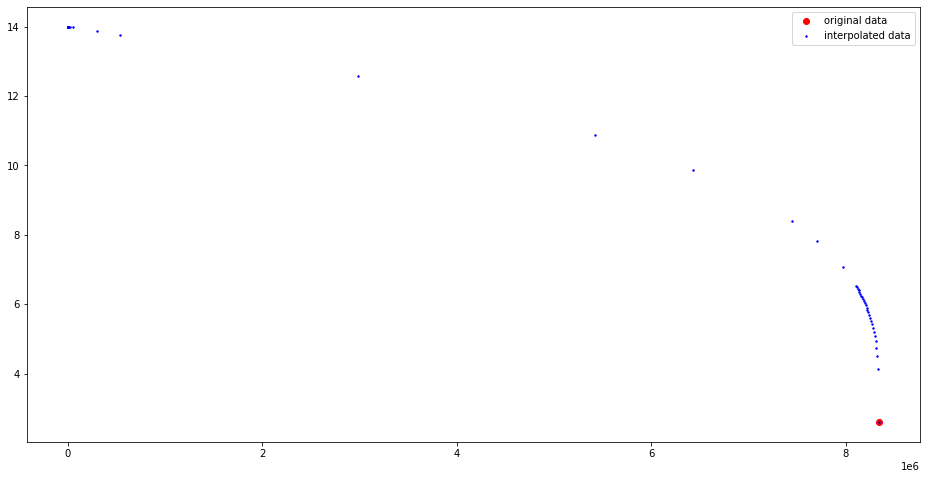

In [262]:
t = res["t"]
new_time_domain=IncreaseArrayDensity(t,npoints)

f = plt.figure(figsize=(16,8))
#plt.scatter(t,p, color="brown", label="Original Data")
plt.scatter(t[-1], fun.separatrix_cutoff, color="red", label="original data")

interp = res["sol"]
newdata = interp(new_time_domain)
plt.scatter(new_time_domain, newdata[0], color="blue", label="interpolated data",s=2)
plt.legend()

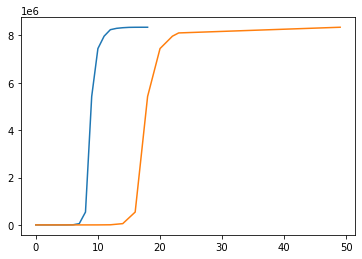

In [264]:
plt.plot(t)
plt.plot(new_time_domain)

In [265]:
M = 1e5
m = 1e1
a = 0.9
p0 = 10.0
e0 = 0.3
iota0 = 0.0
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2

inspiralkwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "npoints":100,
    "dense_output":True
}

# keyword arguments for summation generator (AAKSummation)
sumkwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

MYwfgen = EMRIWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)

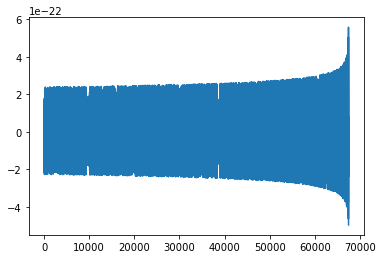

In [266]:
wv = MYwfgen(M,m,a,p0,e0,1.,qS,phiS,qK,phiK,dist,T=5)
plt.plot(wv.real)